In [7]:
import os
import gc
from tqdm import tqdm

import torch
import torch.nn as nn 
from torch.cuda import amp
from torchmetrics import MeanMetric

from inferenceLogger import InferenceLogger, InferType
from modelManager import ModelManager
from utils1 import get_default_device
from visualisations import visualize_data, visualize_forward, visualize_variance_schedule
from dataLoader import get_dataloader
from constantsManager import ConstantsManager

In [2]:
#todo show swiss roll denoising transitions (PLOT_PROCESS)
#todo add texts 
#todo save point logs

#todo sample noise from multivariate distribution
#todo implement reverse process decoder?
#todo add different variance schedules

In [8]:
BaseConfig = {
    'DEVICE' : get_default_device(),
    'DATASET' : "SWISS", # "SWISS", "MNIST", "Cifar-10", "Cifar-100", "Flowers" ...
}

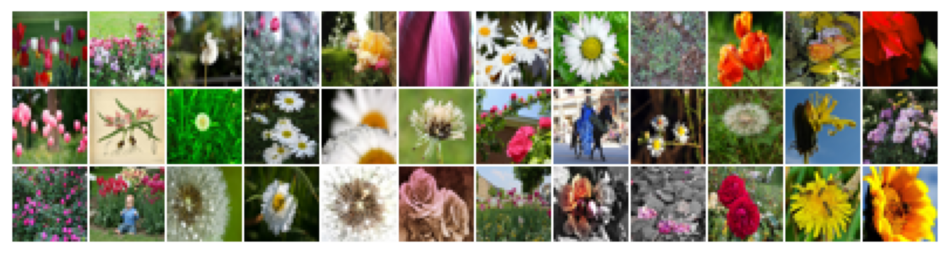

In [6]:
visualize_data(dataset_name="Flowers", amount=36)
# visualize_data(dataset_name="Flowers", amount=72)

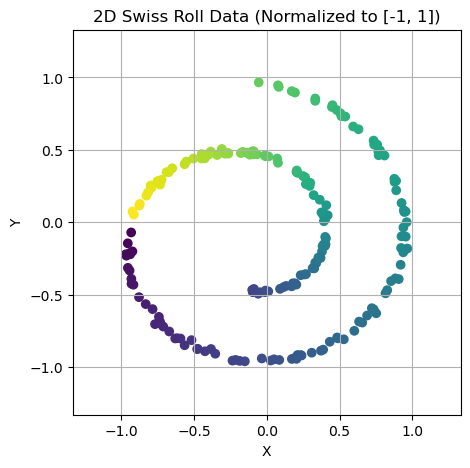

In [53]:
visualize_data(dataset_name=BaseConfig['DATASET'], amount=200)

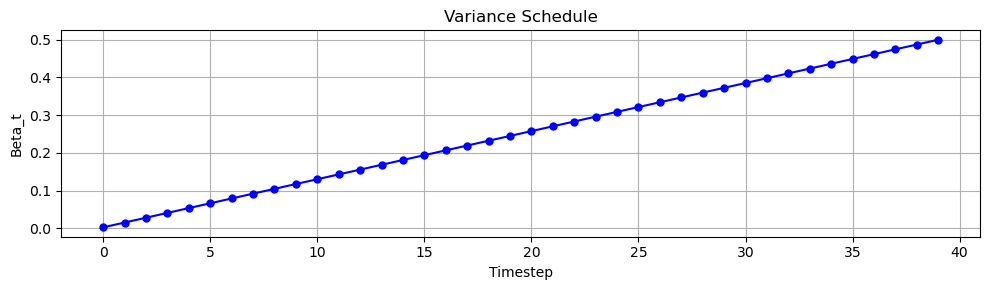

In [8]:
visualize_variance_schedule(timesteps=40)

Forward diffusion:

$$
\Large x_t = \sqrt{\bar a_t}x_0 + \sqrt{1-\bar a_t}\epsilon
$$

In [9]:
def forward_diffusion(constants: ConstantsManager, x0: torch.Tensor, t: torch.Tensor):
    # Noise
    e = torch.randn_like(x0)  
    
    # image scaled + noise scaled
    x_t  = (constants.sqrt_alpha_cumulative_at(timesteps=t) * x0 + constants.sqrt_one_minus_alpha_cumulative_at(timesteps=t) * e)
    
    # return corrupted input and the corresponding noise applied
    return x_t, e   

In [ ]:
visualize_forward("Flowers")

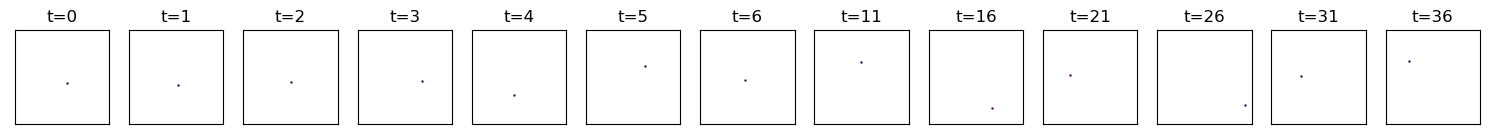

In [6]:
visualize_forward(dataset_name="SWISS", timesteps=40, batch_size=1)
#visualize_forward(dataset_name="SWISS", timesteps=40, batch_size=300)

![](.\resources\training.png)

In [10]:
# Algorithm 1: Training

def train_one_epoch(model, constants, loader, optimizer, scaler, loss_fn, epoch, base_config, training_config):
    
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config['NUM_EPOCHS']}")
    
        # for every batch x0s
        for x0s, _ in loader:
            tq.update(1)
            # select random timestep for every datapoint in x0s
            ts = torch.randint(low=1, high=training_config['TIMESTEPS'], size=(x0s.shape[0],), device=base_config['DEVICE'])
            # perform noising based on the variance schedule
            xts, e = forward_diffusion(constants, x0s, ts)
            
            with amp.autocast():
                # predict the induced noise
                pred_noise = model(xts, ts)
                # compare prediction with actual noise added
                loss = loss_fn(e, pred_noise)
                
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss 

![](.\resources\sampling.png)

In [11]:
# Algorithm 2: Sampling
# generates "num_images"-amount of samples
    
@torch.no_grad()
def generate_samples(model, constants, inference_logger, timesteps, img_shape, num_images, device="cpu"):
    
    # (multiples: x := [x1_T, x2_T ..., x(num_images)_T] )
    x_shape = (num_images, *img_shape) if isinstance(img_shape, tuple) else (num_images, img_shape)
    # 1: x_T ~ N(0,1)
    x = torch.randn(x_shape, device=device)
    model.eval()

    # 2: for t = T, ... ,1 do
    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        # 3: z ~ N(0,1) if t > 0, else z = 0
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        predicted_noise = model(x, ts)

        beta_t                            = constants.beta_at(timesteps=ts)
        one_by_sqrt_alpha_t               = constants.one_by_sqrt_alpha_at(timesteps=ts)
        sqrt_one_minus_alpha_cumulative_t = constants.sqrt_one_minus_alpha_cumulative_at(timesteps=ts)

        # 4: x_{t-1} = ...
        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )
        
        # save progress for video generation
        inference_logger.update(x)

    # 6: return x_0
    # save generated sample in files
    inference_logger.save_result(x)

In [12]:
TrainingConfig = {
    'SAMPLES_AMOUNT' : 1, # amount of test samples, to see progress
    'INFERENCE_TYPE' : InferType.NONE,  # type of sample 
    'TIMESTEPS' : 40, # Define number of diffusion timesteps
    'NUM_EPOCHS' : 100,
    'BATCH_SIZE' : 512,
    'CHECKPOINT_PERIOD' : 50, # how frequently the models state should be saved (in epoches)
    'NUM_WORKERS' : 0 # does not work on windows
}    

# formality for any model configuration
FNNConfig = {
    'IMG_SHAPE' : 2,
}

In [14]:
# load or create model
m = ModelManager(model_name="SwissRoll", model_config=FNNConfig, checkpoint_name=None, type="FNN")
model = m.get_model()

model.to(BaseConfig['DEVICE'])
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()
scaler = amp.GradScaler()

dataloader = get_dataloader(dataset_name=BaseConfig['DATASET'],
                            batch_size=TrainingConfig['BATCH_SIZE'],
                            num_workers=TrainingConfig['NUM_WORKERS'],
                            device=BaseConfig['DEVICE'])

constants = ConstantsManager(
    num_diffusion_timesteps = TrainingConfig['TIMESTEPS'],
    device                  = BaseConfig['DEVICE'],
    shape_2d=BaseConfig['DATASET']=="SWISS"
)

Loaded stored model configuration 
models\SwissRoll\config.json


In [ ]:
# run training
for epoch in range(1, TrainingConfig['NUM_EPOCHS'] + 1):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, constants, dataloader, optimizer, scaler, loss_fn, 
                    epoch=epoch, base_config=BaseConfig, training_config=TrainingConfig)
    
    if epoch % TrainingConfig['CHECKPOINT_PERIOD'] == 0:
        
        if TrainingConfig['INFERENCE_TYPE'] != InferType.NONE:
            # Algorithm 2: Sampling
            generate_samples(
                model, constants, 
                timesteps=TrainingConfig['TIMESTEPS'],
                num_images=TrainingConfig['SAMPLES_AMOUNT'],
                inference_logger= InferenceLogger(
                    TrainingConfig['INFERENCE_TYPE'], 
                    m.get_inference_logs_path()),
                img_shape=m.get_img_shape(), 
                device=BaseConfig['DEVICE'],
            )
        
        m.update_checkpoint(optimizer, scaler, model)
        

# Inference

In [16]:
SWISS_InferenceConfig = {
    'SAMPLES_AMOUNT' : 300,
    'INFERENCE_TYPE' : InferType.PLOT, 
    'TIMESTEPS' : 40
}

Sampling :: 100%|██████████| 39/39 [00:00<00:00, 1205.19it/s]


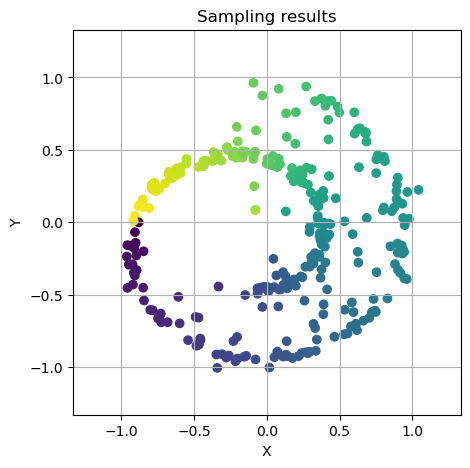

inference_results\denoising_points


In [18]:
# using previously defined model and constants

# swiss roll
os.makedirs("inference_results", exist_ok=True)
filename = "denoising_points"
save_path = os.path.join("inference_results", filename)

generate_samples(
    model,
    constants,
    num_images=300,
    inference_logger=InferenceLogger(InferType.PLOT, save_path),
    timesteps=40,
    img_shape=m.get_img_shape(),
    device=BaseConfig['DEVICE'],
)
print(save_path)

##### for image generation models: